### Notebook format of original code

Code has been adjusted to not plot anything until all iterations are completed, this way we remove plotting overhead. We found this overhead by running the profiler

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from functools import partial

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    train_path = '/content/drive/MyDrive/DD2358_Data/train.csv'
    test_path = '/content/drive/MyDrive/DD2358_Data/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'

"""
Create Your Own Artificial Neural Network for Multi-class Classification (With Python)
Philip Mocz (2023), @PMocz

Create and train your own artificial neural network to classify images of galaxies from SDSS/the Galaxy Zoo project.

Modifications:
 - Removed real-time plotting and sample visualization
 - Accumulate and plot training/validation loss/accuracy at the end
"""

def g(x):
    """ sigmoid function """
    return 1.0 / (1.0 + np.exp(-x))

def grad_g(x):
    """ gradient of sigmoid function """
    gx = g(x)
    return gx * (1.0 - gx)

def predict(Theta1, Theta2, X):
    """ Predict labels in a trained three-layer classification network.
    Input:
      Theta1       trained weights for layer 1 (hidden_layer_size x input_layer_size+1)
      Theta2       trained weights for layer 2 (num_labels x hidden_layer_size+1)
      X            matrix of training data (m x input_layer_size)
    Output:
      prediction   label prediction (m x 1)
    """
    m = np.shape(X)[0]     # number of training values
    num_labels = np.shape(Theta2)[0]

    a1 = np.hstack((np.ones((m,1)), X))   # add bias (input layer)
    a2 = g(a1 @ Theta1.T)                 # apply sigmoid: input --> hidden
    a2 = np.hstack((np.ones((m,1)), a2))  # add bias (hidden layer)
    a3 = g(a2 @ Theta2.T)                 # apply sigmoid: hidden --> output

    prediction = np.argmax(a3, axis=1).reshape((m,1))
    return prediction

def reshape(theta, input_layer_size, hidden_layer_size, num_labels):
    """ Reshape theta into Theta1 and Theta2, the weights of our neural network """
    ncut = hidden_layer_size * (input_layer_size+1)
    Theta1 = theta[0:ncut].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = theta[ncut:].reshape(num_labels, hidden_layer_size+1)
    return Theta1, Theta2

def cost_function(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    """ Neural net cost function for a three-layer classification network. """
    # Unflatten theta
    Theta1, Theta2 = reshape(theta, input_layer_size, hidden_layer_size, num_labels)

    # number of training values
    m = len(y)

    # Feedforward: calculate cost J
    a1 = np.hstack((np.ones((m,1)), X))
    a2 = g(a1 @ Theta1.T)
    a2 = np.hstack((np.ones((m,1)), a2))
    a3 = g(a2 @ Theta2.T)

    # One-hot encode labels
    y_mtx = 1.0 * (y == 0)
    for k in range(1, num_labels):
        y_mtx = np.hstack((y_mtx, 1.0 * (y == k)))

    # cost function
    J = np.sum(-y_mtx * np.log(a3) - (1.0 - y_mtx) * np.log(1.0 - a3)) / m

    # add regularization
    J += (lmbda/(2.0*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    return J

def gradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    """ Neural net cost function gradient for a three-layer classification network. """
    # Unflatten theta
    Theta1, Theta2 = reshape(theta, input_layer_size, hidden_layer_size, num_labels)

    m = len(y)
    Delta1 = np.zeros((hidden_layer_size, input_layer_size+1))
    Delta2 = np.zeros((num_labels, hidden_layer_size+1))

    # Backpropagation
    for t in range(m):
        # forward
        a1 = X[t,:].reshape((input_layer_size,1))
        a1 = np.vstack((1, a1))  # +bias
        z2 = Theta1 @ a1
        a2 = g(z2)
        a2 = np.vstack((1, a2))  # +bias
        a3 = g(Theta2 @ a2)

        # one-hot
        y_k = np.zeros((num_labels,1))
        y_k[int(y[t,0])] = 1
        # compute error for layer 3
        delta3 = a3 - y_k
        Delta2 += (delta3 @ a2.T)

        # compute error for layer 2
        delta2 = (Theta2[:,1:].T @ delta3) * grad_g(z2)
        Delta1 += (delta2 @ a1.T)

    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m

    # add regularization
    Theta1_grad[:,1:] += (lmbda/m) * Theta1[:,1:]
    Theta2_grad[:,1:] += (lmbda/m) * Theta2[:,1:]

    # flatten gradients
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    return grad

# --- Global Variables for Callback ---
N_iter = 1
J_min = np.inf
theta_best = None

# Lists to store metrics per iteration
Js_train = []
Js_test = []
Acc_train = []
Acc_test = []

def callbackF(input_layer_size, hidden_layer_size, num_labels, X, y, lmbda, X_val, y_val, theta_k):
    """ Callback to compute and store stats at each iteration (no real-time plotting). """
    global N_iter
    global J_min
    global theta_best
    global Js_train
    global Js_test
    global Acc_train
    global Acc_test

    # Compute training cost/accuracy
    train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    Theta1, Theta2 = reshape(theta_k, input_layer_size, hidden_layer_size, num_labels)
    y_pred_train = predict(Theta1, Theta2, X)
    train_accuracy = 100.0 * np.sum(y_pred_train == y) / len(y)

    # Compute validation cost/accuracy
    val_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X_val, y_val, lmbda)
    y_pred_val = predict(Theta1, Theta2, X_val)
    val_accuracy = 100.0 * np.sum(y_pred_val == y_val) / len(y_val)

    # Store metrics
    Js_train.append(train_cost)
    Js_test.append(val_cost)
    Acc_train.append(train_accuracy)
    Acc_test.append(val_accuracy)

    # Print iteration stats
    print(f"iter={N_iter:3d}:  "
          f"Train Cost= {train_cost:.4f}  Acc= {train_accuracy:.2f}%  |  "
          f"Val Cost= {val_cost:.4f}    Acc= {val_accuracy:.2f}%")

    # Track best
    if val_cost < J_min:
        J_min = val_cost
        theta_best = theta_k.copy()

    N_iter += 1


In [5]:
np.random.seed(917)

# Load the training and test datasets
train = np.genfromtxt(train_path, delimiter=',')
test = np.genfromtxt(test_path, delimiter=',')

# get labels (0=Elliptical, 1=Spiral, 2=Irregular)
train_label = train[:, 0].reshape(len(train),1)
test_label = test[:, 0].reshape(len(test),1)

# normalize image data to [0,1]
train = train[:, 1:] / 255.
test = test[:, 1:] / 255.

# Data matrices
X = train
y = train_label
X_val = test
y_val = test_label

Input layer size: 1024
Initial cost function J = 2.0368341799643392
Initial accuracy on training set = 33.333333333333336
iter=  1:  Train Cost= 1.9494  Acc= 33.33%  |  Val Cost= 2.0102    Acc= 33.33%
iter=  2:  Train Cost= 1.9412  Acc= 33.33%  |  Val Cost= 2.0019    Acc= 33.33%
iter=  3:  Train Cost= 1.9312  Acc= 33.33%  |  Val Cost= 1.9918    Acc= 33.33%
iter=  4:  Train Cost= 1.9303  Acc= 33.41%  |  Val Cost= 1.9908    Acc= 33.19%
iter=  5:  Train Cost= 1.9302  Acc= 37.44%  |  Val Cost= 1.9907    Acc= 39.85%
iter=  6:  Train Cost= 1.9301  Acc= 33.30%  |  Val Cost= 1.9906    Acc= 37.19%
iter=  7:  Train Cost= 1.9299  Acc= 33.33%  |  Val Cost= 1.9899    Acc= 33.33%
iter=  8:  Train Cost= 1.9291  Acc= 33.33%  |  Val Cost= 1.9874    Acc= 33.33%
iter=  9:  Train Cost= 1.9277  Acc= 33.26%  |  Val Cost= 1.9843    Acc= 33.33%
iter= 10:  Train Cost= 1.9267  Acc= 33.15%  |  Val Cost= 1.9815    Acc= 33.19%
iter= 11:  Train Cost= 1.9264  Acc= 35.70%  |  Val Cost= 1.9806    Acc= 34.81%
iter= 12:

c:\Users\dante\skola\DD2358-Introduction-to-High-Performance-Computing\env\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


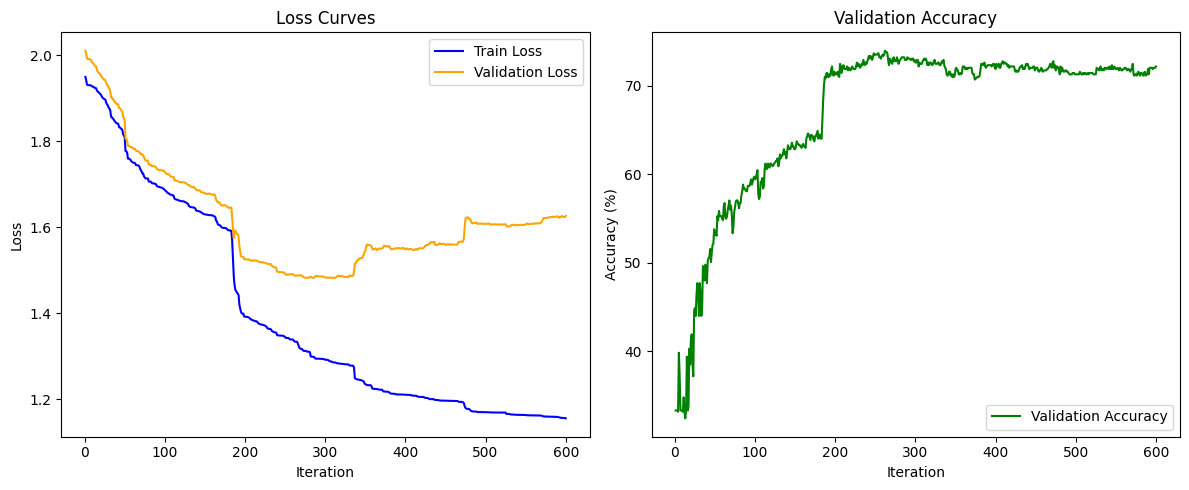

'\n%\n45.3      train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)\n43.8      y_pred_train = predict(Theta1, Theta2, X)\n'

In [6]:
def main():
    """ Artificial Neural Network for classifying galaxies """

    import time
    start_time = time.time()
    # Network parameters
    input_layer_size = X.shape[1]
    hidden_layer_size = 8
    num_labels = 3
    lmbda = 1.0  # regularization parameter

    print("Input layer size:", input_layer_size)

    # Initialize random weights
    Theta1 = np.random.rand(hidden_layer_size, input_layer_size+1) * 0.4 - 0.2
    Theta2 = np.random.rand(num_labels, hidden_layer_size+1) * 0.4 - 0.2

    # Flatten initial guess
    theta0 = np.concatenate((Theta1.flatten(), Theta2.flatten()))

    # Initial cost
    J_init = cost_function(theta0, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    print('Initial cost function J =', J_init)

    # Initial accuracy
    train_pred_init = predict(Theta1, Theta2, X)
    init_acc = 100.0 * np.sum(train_pred_init == y) / len(y)
    print('Initial accuracy on training set =', init_acc)

    # Minimize the cost function using a nonlinear conjugate gradient algorithm
    
    args = (input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    cbf = partial(callbackF, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda, X_val, y_val)
    optimize.fmin_cg(cost_function, theta0, fprime=gradient, args=args, callback=cbf, maxiter=600)

    # Retrieve best found parameters
    if theta_best is None:
        # If no update happened, just use final
        theta_best_local = theta0
    else:
        theta_best_local = theta_best

    # Unflatten final/best theta
    Theta1_best, Theta2_best = reshape(theta_best_local, input_layer_size, hidden_layer_size, num_labels)

    # Final training and test predictions
    train_pred = predict(Theta1_best, Theta2_best, X)
    test_pred = predict(Theta1_best, Theta2_best, X_val)

    final_train_acc = 100.0 * np.sum(train_pred == y) / len(y)
    final_test_acc = 100.0 * np.sum(test_pred == y_val) / len(y_val)

    print(f"Final training accuracy = {final_train_acc:.2f}%")
    print(f"Final test accuracy     = {final_test_acc:.2f}%")

    # --- Plot at the end ---
    iters = np.arange(1, len(Js_train) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(iters, Js_train, label="Train Loss", color="blue")
    plt.plot(iters, Js_test, label="Validation Loss", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iters, Acc_test, label="Validation Accuracy", color="green")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("artificialneuralnetwork.png", dpi=240)
    plt.show()
    elapsed_time = time.time() - start_time
    return 0

main()
#%load_ext line_profiler 
# OBS, the following results are from before the use of Cython


#%lprun -f main main()

# Profile cost_function
#%lprun -f cost_function main()
# Takes approx 2.5 seconds of 25 seconds execution time so 10% of total main function run time (100 training iterations) for one main run, the following two lines takes most of the compute:
# %
# 80.6      a1 = np.hstack((np.ones((m,1)), X)
# 14.0      a2 = g(a1 @ Theta1.T)

# Profile gradient
# %lprun -f gradient main()
# Not this is the main function taking up time, ran for 22.6127 s of a total main function execution time of 28.4 seconds for one main run, about 80% of total training loop computation!
# The following lines took up most of the compute:
""" Backpropagation                         %
   105    526695    1264976.0      2.4      0.6      for t in range(m):
   106                                                   # forward
   107    526500    3999422.0      7.6      1.8          a1 = X[t,:].reshape((input_layer_size,1))
   108    526500   44814604.0     85.1     19.8          a1 = np.vstack((1, a1))  # +bias
   109    526500   10094323.0     19.2      4.5          z2 = Theta1 @ a1
   110    526500   13165740.0     25.0      5.8          a2 = g(z2)
   111    526500   40686589.0     77.3     18.0          a2 = np.vstack((1, a2))  # +bias
   112    526500   17704636.0     33.6      7.8          a3 = g(Theta2 @ a2)
   113                                           
   114                                                   # one-hot
   115    526500    2678032.0      5.1      1.2          y_k = np.zeros((num_labels,1))
   116    526500    4534412.0      8.6      2.0          y_k[int(y[t,0])] = 1
   117                                                   # compute error for layer 3
   118    526500    3059709.0      5.8      1.4          delta3 = a3 - y_k
   119    526500    7737340.0     14.7      3.4          Delta2 += (delta3 @ a2.T)
   120                                           
   121                                                   # compute error for layer 2
   122    526500   27882635.0     53.0     12.3          delta2 = (Theta2[:,1:].T @ delta3) * grad_g(z2)
   123    526500   48369210.0     91.9     21.4          Delta1 += (delta2 @ a1.T)

"""
# So about 80% of our total computation time for training is spent within the backpropogation loop. This is what is expected when training a MLP as the forward pass is way less 
# computationally heavy in comparisson to the backwards pass.


# Profile callbackF
# %lprun -f callbackF main()
# Ran for 2.01368 s out of 26.8 s total execution time for one main run, so a smaller portion of the execution time. The following lines where using the compute:
"""
%
45.3      train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
43.8      y_pred_train = predict(Theta1, Theta2, X)
"""

# OVERALL, the math done within the backpropagation loop within the gradient function is taking up more than 4/5 computational time. 
# Now within the backprop we must speed up the np.vstack calls and other matrix multiplications which shown in the profiling is what is taking so much time within the backpropagation within the gradient function
# 
